# gonna use XGB now to combine the categorical, continuous and pre-embedded free text stuff

#### Online, we import the usual packages. **xgboost** needs to be installed (with conda install xgboost or pip install -U xgboost).

In [29]:
#!pip install xgboost

####  the usual imports

In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from collections import Counter
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import random as rn
from IPython.display import clear_output
import pickle

### load helper functions

In [2]:
def thresholding_analysis(preds, targets, admission_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):

    i = 0
    for thresh in admission_thresholds:
        thresholded_predictions = [0 if prob[0] >= thresh else 1 for prob in preds]
        
        f1_w, f1, acc, prec, rec, auroc = get_metrics(targets,thresholded_predictions, print_output = False)

        if i == 0:
            output_df = pd.DataFrame([thresh, f1_w, f1, acc, prec, rec, rec[0], rec[1]]).T
            output_df.columns = ['admission_threshold', 'AUROC', 'f1', 'accuracy', 'precision', 'recall', 'admission sensitivity', 'admission specificity']
        else:
            output_df.loc[len(output_df)] = [thresh, auroc, f1, acc, prec, rec, rec[0], rec[1]]
        i+=1
    
    return output_df

In [3]:

def show_confusion_matrix2(confusion_matrix, labels):
    LABELS = labels

    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, cmap = 'Blues', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 15});
    plt.title("Confusion matrix", fontsize=10)
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.show()
    
def get_metrics(model, y_test, X_test, show_confusion = True, print_output = True):
    preds = model.predict_proba(X_test)
    predictions = model.predict(X_test)
    
    f1_w = sklearn.metrics.f1_score(y_test, predictions, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, predictions, average=None)
    acc = sklearn.metrics.accuracy_score(y_test, predictions)
    prec = sklearn.metrics.precision_score(y_test,predictions, average=None) 
    rec = sklearn.metrics.recall_score(y_test,predictions, average=None)
    auroc = sklearn.metrics.roc_auc_score(y_test,preds[:,1], average=None)
    confusion = sklearn.metrics.confusion_matrix(y_test, predictions)
    
    tp, fn, fp, tn = confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]
    
    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    
    
    if print_output:
        print ('Metrics Report:')
        print ('---------------')
        print ('weighted f1: ', f1_w)
        print ('AUROC:       ',auroc)
        print ('accuracy:    ', acc)
        print ('precision:   ', prec)
        print ('recall:      ', rec)
        #print ('admission sens: ', rec[0])
        #print ('admission spec: ', rec[1])
        print ('sensitivity: ', sens)
        print ('specificity: ', spec)
        print ('PPV:         ', ppv)
        print ('NPV:         ', npv)
        
    if show_confusion:
        show_confusion_matrix2(confusion, labels = ['admit', 'd/c'])
            
    #return f1_w, f1, acc, prec, rec, auroc




In [4]:
def JJ_gridsearch(weights, print_output = False):
    epoch = 0
    for weight in weights:
        
        xgc = xgb.XGBClassifier(scale_pos_weight=weight)
        xgc.fit(X_train, y_train)
        preds = xgc.predict(X_test)
        probas = xgc.predict_proba(X_test)
        f1_w, f1, acc, prec, rec = get_metrics(y_test, preds, print_output)
        
        if epoch == 0:
            results_df = pd.DataFrame([epoch+1, 1/weight, f1_w, f1, acc, prec, rec, rec[0], rec[1]]).T
            results_df.columns = ['trial number', 'class penalty', 'weighted f1', 'f1', 'accuracy', 'precision', 'recall', 'admission sensitivity', 'admission specificity']
        else:
            results_df.loc[len(results_df)] = [epoch+1, 1/weight, f1_w, f1, acc, prec, rec, rec[0], rec[1]]
        
        epoch +=1
        
    return xgc, results_df, preds, probas

In [5]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project/combo'
model_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage/models'

In [6]:
clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [7]:
dx_code_dict = {code:i for i,code in enumerate(set(clin['MainDiagnosisCode']))}

def convert_dxcode(s):
    code = dx_code_dict[s]
    return (code)

clin['recoded_diagnosis'] = clin['MainDiagnosisCode'].map(convert_dxcode)

In [16]:
medhx = np.load(data_path + '/medhx_embeds.npy')

#this is the admit vs d/c target
target = np.load(data_path + '/admit_dc_target.npy')

subjnotes = np.load(data_path + '/subj_emeds.npy')


In [8]:
#this cell will define the various groupings of variables from the dataframe
dx_vars = ['recoded_diagnosis', 'PresentingComplaint']

cont_vars = [ 'Triage Date & TimeYear', 'Triage Date & TimeMonth', 'Triage Date & TimeWeek', 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek', 'Triage Date & TimeDayofyear', 'Triage Date & TimeHour', 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond', 'Triage Date & TimeElapsed',
 'num_comorbids','systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs']


cos_date_vars = ['Triage Date & Timeweekday_cos',
       'Triage Date & Timeweekday_sin', 'Triage Date & Timeday_month_cos',
       'Triage Date & Timeday_month_sin', 'Triage Date & Timemonth_year_cos',
       'Triage Date & Timemonth_year_sin', 'Triage Date & Timeday_year_cos',
       'Triage Date & Timeday_year_sin', 'Triage Date & Timehour_cos',
       'Triage Date & Timehour_sin', 'Triage Date & Timeclock_cos',
       'Triage Date & Timeclock_sin', 'Triage Date & Timemin_cos',
       'Triage Date & Timemin_sin', 'Triage Date & Timesec_cos']

cat_vars = ['Triage Date & TimeIs_month_end',
 'Triage Date & TimeIs_month_start',
 'Triage Date & TimeIs_quarter_end',
 'Triage Date & TimeIs_quarter_start',
 'Triage Date & TimeIs_year_end',
 'Triage Date & TimeIs_year_start',
 'GenderDesc', 'TriageLevel', 'site']

inf_control_vars = ['Are you feeling feverish or have had shakes or chills in the last 24 hours?',
 'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
 'Do you have a new Rash?',
 'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
 'Have you travelled outside of Canada/USA in the last 3 weeks?',
 'Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?',
 'Have you received Health Care in another country in the last 2 years?',
 'Do you have a new/worse cough or shortness of breath?',
 'If so, select all countries that apply',
 'If so, select all infectious diseases that apply']

### preprocessing variables to use in XGB

In [18]:
#need to preprocess cat vars for xgb
X = clin[cat_vars + inf_control_vars].values.astype(str)

features = []
for i in range(0, X.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    features.append(feature)
encoded_x = np.array(features)
encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])

In [19]:
encoded_x.shape

(165433, 19)

In [20]:
X2 = clin[dx_vars].values.astype(str)
encoded_x2 = None
for i in range(0, X2.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X2[:,i])
	feature = feature.reshape(X2.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x2 is None:
		encoded_x2 = feature
	else:
		encoded_x2 = np.concatenate((encoded_x2, feature), axis=1)
print("X shape: : ", encoded_x2.shape)

X shape: :  (165433, 3702)


In [21]:
#splitting this one hot encoded matrix into one for the presenting complaint and one for the medical history
X_pres = encoded_x2[:,:169]

X_dx = encoded_x2[:,169:]

### gonna do this first pass with just tabular type variables

In [47]:
features = np.concatenate((encoded_x,X_pres, X_dx, clin[cont_vars].values), axis =1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

xgc = xgb.XGBClassifier(scale_pos_weight = 1/9)
%time xgc.fit(X_train, y_train)

preds = xgc.predict(X_test)
predictions = xgc.predict_proba(X_test)

f1_w, f1, acc, prec, rec, auroc = get_metrics(y_test, preds, predictions, print_output=True)

CPU times: user 11min 47s, sys: 14.6 s, total: 12min 1s
Wall time: 12min 20s


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


weighted f1:  0.8253321711774023
AUROC:        0.8435397539725125
accuracy:     0.7883411107618656
precision:    [0.27643203 0.96312273]
recall:       [0.71905115 0.79585656]
admission sens:  0.7190511489992587
admission spec:  0.7958565608919382


### now gonna repeat the process with the embedded subjective notes

In [48]:
#X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(subjnotes, target, random_state=1)

xgc2 = xgb.XGBClassifier(scale_pos_weight = 1/9)
%time xgc2.fit(X_train2, y_train2)

preds2 = xgc2.predict(X_test2)
predictions2 = xgc2.predict_proba(X_test2)

f1_w, f1, acc, prec, rec, auroc = get_metrics(y_test2, preds2, predictions2, print_output=True)

CPU times: user 11min 14s, sys: 6.03 s, total: 11min 20s
Wall time: 11min 46s


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


weighted f1:  0.7358339767372062
AUROC:        0.7294625773130553
accuracy:     0.669165115210716
precision:    [0.17884282 0.94824904]
recall:       [0.66296022 0.66983812]
admission sens:  0.662960217445021
admission spec:  0.6698381217838765


###  now gonna do this with just the embedded medical history column

In [49]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(medhx, target, random_state=1)

xgc3 = xgb.XGBClassifier(scale_pos_weight = 1/9)
%time xgc3.fit(X_train3, y_train3)

preds3 = xgc3.predict(X_test3)
predictions3 = xgc3.predict_proba(X_test3)

f1_w, f1, acc, prec, rec, auroc = get_metrics(y_test3, preds3, predictions3, print_output=True)


CPU times: user 5min 32s, sys: 4.09 s, total: 5min 36s
Wall time: 5min 48s


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


weighted f1:  0.7382562301967925
AUROC:        0.6976412193709336
accuracy:     0.6725742885466283
precision:    [0.17471737 0.94406666]
recall:       [0.63009637 0.6771816 ]
admission sens:  0.6300963676797627
admission spec:  0.6771816037735849


### this now the entire dataset combined

In [22]:
features = np.concatenate((encoded_x,X_pres, X_dx, clin[cont_vars].values), axis =1)
all_features = np.concatenate((features,subjnotes,medhx), axis = 1)
all_features.shape

(165433, 5274)

In [51]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(all_features, target, random_state=1)

xgc4 = xgb.XGBClassifier(scale_pos_weight = 1/9)
%time xgc4.fit(X_train4, y_train4)

preds4 = xgc4.predict(X_test4)
predictions4 = xgc4.predict_proba(X_test4)

f1_w, f1, acc, prec, rec, auroc = get_metrics(y_test4, preds4, predictions4, print_output=True)


CPU times: user 27min 31s, sys: 57.6 s, total: 28min 28s
Wall time: 29min 37s


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


weighted f1:  0.821537657718788
AUROC:        0.8482432551206853
accuracy:     0.7826591552020117
precision:    [0.27371795 0.96524196]
recall:       [0.73857178 0.78744104]
admission sens:  0.7385717815665925
admission spec:  0.7874410377358491


In [56]:
xgc4

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

In [ ]:
#added in hospital site as a variable

X_train5, X_test5, y_train5, y_test5 = train_test_split(all_features, target, random_state=1)

xgc5 = xgb.XGBClassifier(scale_pos_weight = 1/9)
%time xgc5.fit(X_train5, y_train5)

preds5 = xgc5.predict(X_test5)
predictions5 = xgc5.predict_proba(X_test5)

f1_w, f1, acc, prec, rec, auroc = get_metrics(y_test5, preds5, predictions5, print_output=True)

#### gonna train everything with only BCH and then only EGH to see if results are better for a single instition

In [43]:
bch = clin[clin['site']=='BCH']

bch_idx = list(bch.index)

bch_features = all_features[bch_idx]
bch_features.shape

bch_target = target[bch_idx]

(102128, 122)

In [55]:
Counter(bch_target)

Counter({1.0: 92436, 0.0: 9692})

In [58]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(bch_features, bch_target, random_state=1)

xgc6 = xgb.XGBClassifier(scale_pos_weight = 1/9)
%time xgc6.fit(X_train6, y_train6)

preds6 = xgc6.predict(X_test6)
predictions6 = xgc6.predict_proba(X_test6)

f1_w, f1, acc, prec, rec, auroc = get_metrics(y_test6, preds6, predictions6, print_output=True)

CPU times: user 16min 56s, sys: 15.1 s, total: 17min 11s
Wall time: 17min 31s


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


weighted f1:  0.8391177666887858
AUROC:        0.8599960626091043
accuracy:     0.8043239855867147
precision:    [0.28297244 0.96784318]
recall:       [0.73404255 0.81144854]
admission sens:  0.7340425531914894
admission spec:  0.8114485376585282


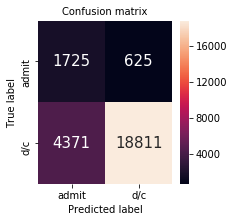

In [66]:
confusion = show_confusion_matrix(y_test6, preds6, labels = ['admit', 'd/c'])

#### refactoring metrics calculation

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8391177666887858
AUROC:        0.8599960626091043
accuracy:     0.8043239855867147
precision:    [0.28297244 0.96784318]
recall:       [0.73404255 0.81144854]
sensitivity:  0.7340425531914894
specificity:  0.8114485376585282
PPV:          0.2829724409448819
NPV:          0.9678431776085614


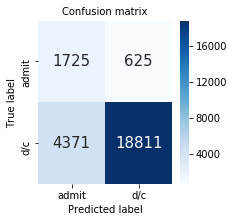

In [97]:
get_metrics(xgc6, y_test6, X_test6)

In [98]:
egh = clin[clin['site']=='EGH']

egh_idx = list(egh.index)

egh_features = all_features[egh_idx]
print(egh_features.shape)

egh_target = target[egh_idx]

(63305, 5274)


In [99]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(egh_features, egh_target, random_state=1)

xgc7 = xgb.XGBClassifier(scale_pos_weight = 1/9)
%time xgc7.fit(X_train7, y_train7)

#preds7 = xgc6.predict(X_test6)
#predictions6 = xgc6.predict_proba(X_test6)

CPU times: user 10min 28s, sys: 8 s, total: 10min 36s
Wall time: 11min


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.818801495849663
AUROC:        0.8501875982009937
accuracy:     0.7815126050420168
precision:    [0.29075708 0.9649336 ]
recall:       [0.75603865 0.78448945]
sensitivity:  0.7560386473429952
specificity:  0.784489450285795
PPV:          0.2907570831398049
NPV:          0.9649335995139311


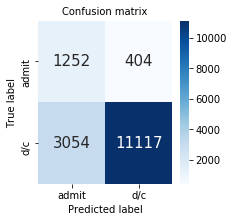

In [100]:
get_metrics(xgc7,y_test7, X_test7)

#### creating a one hot encoded diagnosis list

In [17]:
history = list(clin['MedicalHistory'].str[16:].astype('str'))

In [18]:
#this is to clean the text in the medical history column (a little bit)
def fixhx(s):
    s =s.replace('<LT><LF>','')
    s = s.replace('<LT>LF>','')
    s =s.replace('Pt.', 'patient')
    s =s.replace('Pt', 'patient')
    s = s.lower()
    s = s.replace('pt.', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('sob', 'shortness of breath')
    s = s.replace('c/p', 'chest pain')
    s = s.replace('hrs', 'hours')
    s = s.replace('hx', 'history')
    s = s.replace('n/v', 'nausea and/or vomiting')
    s = s.replace('a/e', 'air entry')
    s = s.replace('a/o', 'alert and oriented')
    s = s.replace('a&o', 'alert and oriented')
    s = s.replace('d/c', 'discharge')
    s = s.replace('u/s', 'ultrasound')
    s = s.replace('yrs', 'years')
    s = s.replace('lmp', 'last menstrual period')
    s = s.replace('w/', 'with')
    s = s.replace('@', 'at ')
    s = s.replace('b/c', 'because')
    s = re.sub(r'\bpt.','patient ',s)
    s = re.sub(r'\blt.','left ',s)
    s = re.sub(r'\brt.','right ',s)
    s = re.sub(r'\bmd.','doctor ',s)
    s = re.sub(r'\bra\b','room air ',s)
    s = re.sub(r'\bbp.','blood pressure ',s)
    s = re.sub(r'\bcp.','chest pain ',s)
    s = re.sub(r'\bfd.','family doctor ',s)
    s = s.replace('abx', 'antibiotics')
    s = s.replace(' htn ', ' hypertension ')
    s = re.sub(r'\btyl\b', 'tylenol', s)
    s = re.sub(r'\bprn\b', 'as needed ',s)
    s = re.sub(r'\bvag\b', 'vaginal ',s)
    s = re.sub(r'\bpo\b', 'by mouth ',s)
    s = re.sub(r'\bllq\b', 'left lower quadrant',s)
    s = re.sub(r'\brlq\b', 'right lower quadrant  ',s)
    s = re.sub(r'\bluq\b', 'left upper quadrant',s)
    s = re.sub(r'\bruq\b', 'right upper quadrant  ',s)
    s = re.sub(r'\buti\b', 'urinary tract infection ',s)
    s = re.sub(r'\brd', 'right digit number',s)
    s = re.sub(r'\bld', 'left digit number',s)
    s = re.sub(r'\br\b', 'right ',s)
    s = re.sub(r'\bl\b', 'left ',s)
    s = re.sub(r'\bed\b', 'emergency department ',s)
    s = re.sub(r'\ber\b', 'emergency room ',s)
    s = re.sub(r'\bbm\b', 'bowel movement ',s)
    s = re.sub(r'#\s', 'fracture ', s)
    
    #remove extra white spaces
    s = re.sub(r'\s+', ' ', s)

    #note that what's missing here is removal of punctuation
    return s

In [19]:
replacements = (',','<LT>LF>', '.')
drop_list = ('"', '?')
split_hist = []
for item in history:
    for r in replacements:
        item = item.replace(r, '::')
    
    item = item.split('::')
    
    item = [re.sub(r'\(.*?\)\ *', '', s) for s in item]
    
    item = [fixhx(s) for s in item]
    for d in drop_list:
        item = [x.replace(d,'') for x in item]
    
    item = [x.strip().lower() for x in item if x != 'nan']
    item = [x for x in item if len(x) > 2]
    
    item = list(filter(None, item))
    
    split_hist.append(item)
    

In [24]:
diagnoses = Counter()
for hx in split_hist:
    for item in hx:
        diagnoses[item] += 1

len(diagnoses)

23721

In [41]:
#making a dictionary of the top 1000 diagnosis
class_dict = {finding[0]:i for i,finding in enumerate(diagnoses.most_common(1999))}; len(class_dict)

1999

In [42]:
#this creates a large array containing a 1 in each column where there is a diagnosis (for each xray)
complete_findings = np.empty((len(data), 2000))
for idx,findings in enumerate(split_hist):
    findings_array = np.zeros(2000)
    for finding in findings:
        try:
            findings_array[class_dict[finding]] = 1
        except:
            findings_array[1999] = 1
    complete_findings[idx,:]= findings_array

In [43]:
#this turns the above array into a dataframe
findings_df = pd.DataFrame(complete_findings.astype(int), columns = list(class_dict.keys()) + ['other']); findings_df.head(10)

,no significant medical history,hypertension,high cholesterol,niddm,htn,asthma,high bp,depression,thyroid,anxiety,...,lyme disease,narrow tricuspid valve,wisdom tooth extraction,acute pancreatitis,chronic leukemia,sleeping problems,esophagectomy,low k,skin condition,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### now to train the classifier using findings_df

In [44]:
features = findings_df.values
targets = clin.target3

CPU times: user 10min 37s, sys: 15.6 s, total: 10min 53s
Wall time: 12min 58s



/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.5989933305792756
AUROC:        0.69107768573994
accuracy:     0.5096109673831573
precision:    [0.14188027 0.95554248]
recall:       [0.79466271 0.47869318]
sensitivity:  0.7946627131208303
specificity:  0.4786931818181818
PPV:          0.1418802664666696
NPV:          0.9555424780654825


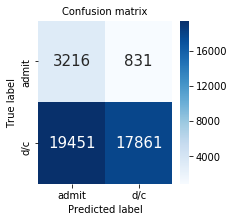

In [46]:
X_train8, X_test8, y_train8, y_test8 = train_test_split(features, targets, random_state=1)

xgc8 = xgb.XGBClassifier(scale_pos_weight = 1/9)
%time xgc8.fit(X_train8, y_train8)
print ()
get_metrics(xgc8,y_test8, X_test8)

### now gonna try to save these models

In [54]:
import pickle

In [55]:
pickle.dump(xgc, open(data_path + "/tabular_xgb_model.pkl", "wb"))
pickle.dump(xgc2, open(data_path + "/subjnotes_xgb_model.pkl", "wb"))
pickle.dump(xgc3, open(data_path + "/med_hx_xgb_model.pkl", "wb"))
pickle.dump(xgc4, open(data_path + "/combined_xgb_model.pkl", "wb"))

### now gonna reload the ensembled model to do some new analysis on it

In [ ]:
# for reloading later
with open(data_path + "/combined_xgb_model.pkl", mode = 'rb') as pkl:
    xgc4 = pickle.load(pkl)

In [ ]:
features = np.concatenate((encoded_x,X_pres, X_dx, clin[cont_vars].values), axis =1)

all_features = np.concatenate((features,subjnotes,medhx), axis = 1)
all_features.shape

X_train4, X_test4, y_train4, y_test4 = train_test_split(all_features, target, random_state=1)

In [ ]:
preds4 = xgc4.predict(X_test4)
predictions4 = xgc4.predict_proba(X_test4)

f1_w, f1, acc, prec, rec, auroc = get_metrics(y_test4, preds4, print_output=True)

thresholding_analysis(predictions4, y_test4)